Sketch of an optimizer module (top left) and a single synapse (bottom right, simply a 2T1C DRAM cell)

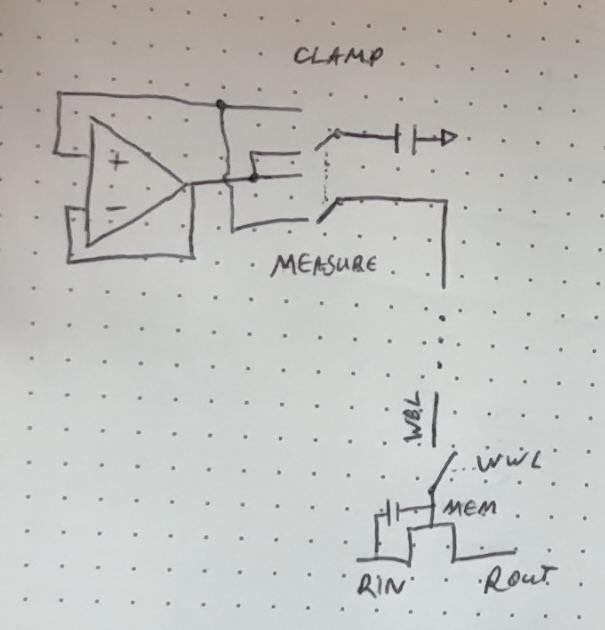

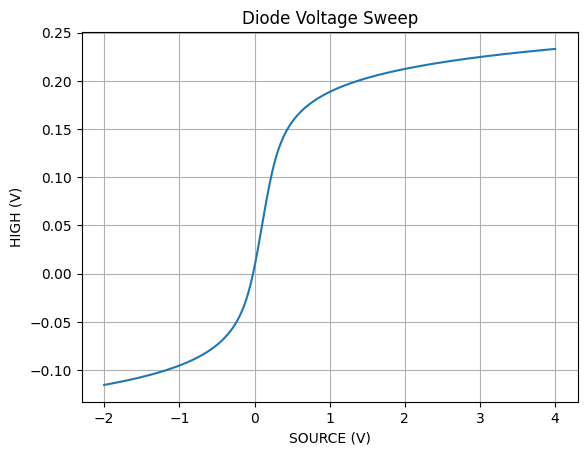

In [23]:
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory, DeviceModel
from PySpice.Unit import u_V, u_mV, u_ps, u_ns, u_us, u_ms, u_Ohm, u_kOhm, u_uF, u_uA, u_pF, u_A, u_s
import matplotlib.pyplot as plt
import torch
from torch import nn
import os, warnings, tqdm, logging
import numpy as np

# Create a circuit
circuit = Circuit('Diode Voltage Sweep')

# Add a diode to the circuit
circuit.model('D', 'D')
circuit.V('offset', 'inner', '0', (0.65-0.1)@u_V)
circuit.D(1,        'inner', 'mid', model='D')

circuit.V('offset2', 'inner2', 'mid', 0.65-0.2@u_V)
circuit.D(2,        'inner2', '0', model='D')

        #self.V('dio', 'DIO', '0', 0.65@u_V)
        #self.D('dio', 'DIO', 'OUT', model='diode')

        #self.V('dio', 'DIO', 'OUT', 0.0@u_V)
        #self.D('dio', 'DIO', '0', model='diode')
# Add a voltage source to the circuit
circuit.R('a',  'a', 'mid', 1000@u_Ohm)
circuit.R('b', 'mid', circuit.gnd, 1000@u_Ohm)
circuit.V(1, 'a', circuit.gnd, 0@u_V)

# Create a simulator
simulator = circuit.simulator(temperature=25, nominal_temperature=25, simulator="xyce-parallel")

# Perform a DC sweep
analysis = simulator.dc(V1=slice(-2, 4, 0.01))

# Plot the results
plt.figure()
plt.plot(analysis['a'], np.array(analysis['mid']))
plt.xlabel('SOURCE (V)')
plt.ylabel('HIGH (V)')
plt.title('Diode Voltage Sweep')
plt.grid()
plt.show()


# Fast Learner

In [111]:
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory, DeviceModel
from PySpice.Unit import u_V, u_mV, u_ps, u_ns, u_us, u_ms, u_Ohm, u_kOhm, u_uF, u_uA, u_pF, u_A, u_s
import matplotlib.pyplot as plt
import torch
from torch import nn
import os, warnings, tqdm, logging
import numpy as np

# Synapse: performing a nonlinear analog "multiplication" between weights (MEM) and currents (RIN)
class Synapse(SubCircuitFactory):
    def __init__(self, cap, bound_weight=0, lower=-0.3):
        self.NAME = 'synapse'
        self.NODES = ('WWL', 'WBL', 'RIN', 'ROUT')
        super().__init__()
        
        self.S('write_nfet', 'MEM', 'WBL', 'WWL', self.gnd, model='switch')
        self.C('cap', 'MEM', 'ROUT', cap*100, model='capacitor')
        self.M("read_nfet", 'ROUT', 'MEM', 'RIN', 'RIN', model='NMOSS', l=5e-6, w=5e-6)
        #self.X('read_nfet', 'sky130_fd_pr__nfet_01v8', 'ROUT', 'MEM', 'RIN', 'RIN', l=0.15, w=1.0)
        #self.R(f'out', f'OUT', '0', 20000@u_Ohm)
        if False:#lower is not None:
            self.V('diol', 'DIOL', 'ROUT', (0.65+lower)@u_V)
            self.D('diol', 'DIOL', 'MEM', model='diode')


# Amplifier: a (linear) activation function between layers, amplifying voltages forward and currents backward
class Amplifier(SubCircuitFactory):
    def __init__(self, v_gain, i_gain, shift, lower=None, upper=0.9):
        self.NAME = 'amplifier'
        self.NODES = ('IN', 'OUT')
        super().__init__()
        if (v_gain is not None) and (i_gain is not None):
            self.B('vcvs', 'OUT', self.gnd, voltage_expression=f'{{{shift} + {v_gain} * (V(IN)-{shift})}}')
            self.B('cccs', 'INN', self.gnd, current_expression=f'{{{-i_gain} * I(Bvcvs)}}') #{{{-1/gain} * I(Bvcvs)}}
        else:
            self.R("short", "INN", "OUT", 0.0@u_Ohm) # shorting, should be equivalent to gain=1
        self.R("meas", "IN", "INN", 0.001@u_Ohm)

        if lower is not None:
            self.V('diol', 'DIOL', '0', (0.65+lower)@u_V)
            self.D('diol', 'DIOL', 'IN', model='diode')
        if upper is not None:
            self.V('diou', 'DIOU', 'IN', (0.65-upper)@u_V)
            self.D('diou', 'DIOU', '0', model='diode')

# Optimizer: measures Vg during NUDGED phase, clamps it during FREE phase
class Optimizer(SubCircuitFactory):
    def __init__(self, cap, factor=1):
        self.NAME = 'optimizer'+str(factor)
        self.NODES = ['WBL', 'FREE', 'NUDGED', 'UPDATE', 'NUDGED_OUTER']
        super().__init__()

        self.B('opamp', 'OUT', self.gnd, voltage_expression='{V(WBL)*V(NUDGED_OUTER)/1.95}')
        self.S('store', 'OUT', 'STORE', 'NUDGED', self.gnd, model='switch')
        self.C('store', 'STORE', self.gnd, cap*factor*1, model='capacitor')
        self.S('read', 'STORE', 'WBL', 'UPDATE', self.gnd, model='switch')


class MLP(SubCircuitFactory):
    def __init__(self, dims, weights, X, Y, cols_to_update, beta, v_gain, i_gain, shift, cap=0.05@u_pF,
                 write_start=10@u_ns, write_width=2*50@u_ns, write_pause=2*50@u_ns, write_change=10@u_ns,
                 bitline_offset=20@u_ns, read_width=2*40@u_ns, read_pause=2*70@u_ns, read_change=10@u_ns
        ):
        self.NAME   = 'mlp' 
        self.NODES = ['NUDGED', 'FREE']
        self.NODES += [f'X_{i}' for i in range(dims[0])]
        self.NODES += [f'Y_{j}_{phase}' for j in range(dims[-1]) for phase in ["NUDGED"]]
        super().__init__()
        self.model('switch',  'VSWITCH', VON=0.5@u_V, VOFF=0.4@u_V, ROFF=1e11@u_kOhm, RON=0.0001@u_Ohm)
        self.model( # modeled after: https://raw.githubusercontent.com/google/skywater-pdk-libs-sky130_fd_pr/f62031a1be9aefe902d6d54cddd6f59b57627436/cells/nfet_01v8/sky130_fd_pr__nfet_01v8.pm3.spice
            'NMOSS', 'NMOS', LEVEL=54, VTO=0.7, L=0.15, W=10, TOX=4.148e-9, XJ=1.5e-7, NDEP=1.7e17,
            NSUB=1.0e20, RSH=0.1, U0=0.030197, VSAT=176320, K1=0.90707349, K2=-0.12949, K3=2.0, DVT0=0.0,
            DVT1=0.53, DVT2=-0.032, ETA0=0.00069413878, NFACTOR=2.015, VOFF=-0.20753, RDSW=65.968, PRWG=0.021507,
            PRWB=0.0, WINT=2.1859e-8, LINT=1.1932e-8, CGSO=2.54e-10, CGDO=2.54e-10, CGBO=1.0e-13, KETA=0.0, A0=1.5,
            AGS=1.25, B0=0.0, B1=0.0, A1=0.0, A2=0.42385546, PCLM=0.14094, PDIBLC1=0.35697215,
            PDIBLC2=0.0084061121, PDIBLCB=-0.10329577, DR0UT=0.50332666, PSCBE1=7.9141988e+8, PSCBE2=1.0e-12,
            PVAG=0.0, DELTA=0.01, ALPHA0=3.0e-8, ALPHA1=0.85, BETA0=13.85
        )
        self.model('diode', 'D')
        self.model('capacitor', 'C')
        self.subcircuit(Synapse(cap=cap))
        self.subcircuit(Amplifier(v_gain, i_gain, shift))
        self.subcircuit(Optimizer(cap=cap, factor=1))
        self.subcircuit(Optimizer(cap=cap, factor=100))

        d_in, d_hidden, d_out = dims

        # Crossbar
        for h in range(d_hidden):
            for i in range(d_in):
                self.X(f'weight_I{i}_H{h}', 'synapse', f'WWL_I{i}', f'WBL_IN_H{h}', f'X_{i}', f'IN_H{h}')
            self.X(f'act_H{h}', 'amplifier', f'IN_H{h}', f'OUT_H{h}')
            for j in range(d_out):
                self.X(f'weight_J{j}_H{h}', 'synapse', f'WWL_J{j}', f'WBL_OUT_H{h}', f'OUT_H{h}', f'Y_{j}')
            for _ in ("IN", "OUT"):
                self.X(f'optim_{_}_H{h}',  'optimizer100' if _=="IN" else 'optimizer1',  f'WBL_{_}_H{h}',  'FREE', 'NUDGED', 'UPDATE', 'NUDGED_OUTER')
                self.S(f'set_{_}_H{h}', f'SET_{_}_H{h}',  f'WBL_{_}_H{h}', 'SET', self.gnd, model='switch') # connects bit line to weight setting voltage
                self.S(f'GND_{_}_H{h}', f'{_}_H{h}', self.gnd, 'SET', self.gnd, model='switch') # ensures read line is grounded during weight set

        # Output
        for j in range(d_out):
            self.S(f'Y_{j}_NUDGED', f'Y_{j}', f'Y_{j}_NUDGED', 'NUDGED_OUTER', self.gnd, model='switch') # switch connecting to nudging voltage
            self.S(f'Y_{j}_FREE',   f'Y_{j}', f'Y_{j}_FREE',   'FREE', self.gnd, model='switch') # switch connecting to nudging voltage
            self.C(f'Y_{j}_FREE', f'Y_{j}_FREE', self.gnd, cap, model='capacitor')
            self.R(f'Y_{j}', f'Y_{j}', self.gnd, 10@u_kOhm)
            #self.S(f'ref_J{j}', f'Y_{j}', 'REF', f'WWL_J{j}', self.gnd, model='switch')

        # Weight Set
        write_period = write_width + write_pause + 2 * write_change
        wwl_set_times  = [[]] * max(d_in, d_out)
        wwl_set_values = [[]] * max(d_in, d_out)
        for j in range(max(d_in, d_out)):
            wwl_set_times[j] = [0@u_ns, write_start+write_period*j, write_start+write_period*j+write_change,
                                write_start+write_period*j+write_change+write_width,
                                write_start+write_period*j+2*write_change+write_width]
            wwl_set_values[j] = [0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V]
        
        for h in range(d_hidden):
            times  = [0@u_ns]
            in_values = [0@u_V]
            out_values = [0@u_V]
            for j in range(max(d_in, d_out)):
                    times += [write_start+bitline_offset+write_period*j, write_start+bitline_offset+write_period*j+write_change,
                              write_start+bitline_offset+write_period*j+write_change+write_width,
                              write_start+bitline_offset+write_period*j+2*write_change+write_width]
                    in_values  += [0@u_V, weights[0][j, h].item()@u_V, weights[0][j, h].item()@u_V, 0@u_V] if j<d_in  else [0@u_V]*4
                    out_values += [0@u_V, weights[1][h, j].item()@u_V, weights[1][h, j].item()@u_V, 0@u_V] if j<d_out else [0@u_V]*4
            self.PieceWiseLinearVoltageSource(f'SET_IN_H{h}',  f'SET_IN_H{h}',  self.gnd, values=zip(times, in_values))
            self.PieceWiseLinearVoltageSource(f'SET_OUT_H{h}', f'SET_OUT_H{h}', self.gnd, values=zip(times, out_values))
        
        weight_set_duration = write_start + write_pause + max(d_in, d_out) * write_period
        times  = [0@u_ns, weight_set_duration, weight_set_duration+write_change]
        values = [1.95@u_V, 1.95@u_V, 0@u_V]
        self.PieceWiseLinearVoltageSource(f'SET', f'SET', self.gnd, values=zip(times, values))
        
        ## Train
        start = weight_set_duration + 2 * write_change + read_pause
        read_period = read_width + read_pause + 2 * read_change
        times = [0@u_ns, start]
        times_outer  = [0@u_ns, start]
        times_inner  = [0@u_ns, start] # pulse slightly shortened by 2*bitline_offset
        times_innerupdate_outerelse = [0@u_ns, start]
        xvalues = [[0@u_V, 0@u_V,] for i in range(dims[0])]
        yvalues = [[0@u_V, 0@u_V] for i in range(Y.shape[1])]
        nudged  = [0@u_V, 0@u_V,]
        free    = [0@u_V, 0@u_V,]
        update  = [0@u_V, 0@u_V,]
        n, d_in = X.shape
        for i in range(n):
            for phase in range(3): # 'FREE', 'NUDGED', 'UPDATE'
                times +=       [start+read_period*((i+1)*3+phase), start+read_period*((i+1)*3+phase)+read_change, start+read_period*((i+1)*3+phase)+read_change+read_width, start+read_period*((i+1)*3+phase)+2*read_change+read_width]
                times_outer += [times[-4]-bitline_offset, times[-3]-bitline_offset, times[-2]+bitline_offset, times[-1]+bitline_offset]
                times_inner += [times[-4]+bitline_offset, times[-3]+bitline_offset, times[-2]-bitline_offset, times[-1]-bitline_offset]
                times_innerupdate_outerelse += times_inner[-4:] if phase % 3 == 2 else times_outer[-4:]
            free   += [0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V] # ___|--|_____________ FREE
            nudged += [0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V] # ________|--|________ NUDGED
            update += [0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V] # _____________|--|___ UPDATE
            for d in range(dims[0]):                                                                             # __|---------------|_________ X
                xvalues[d] += ([0@u_V] + [X[i,d].item()@u_V] * 10 + [0@u_V])
            for d in range(Y.shape[1]):
                yvalues[d] += ([0@u_V] + [Y[i,d].item()@u_V] * 10 + [0@u_V])
        
        self.PieceWiseLinearVoltageSource(f'NUDGED', 'NUDGED', '0', values=zip(times, nudged))
        self.PieceWiseLinearVoltageSource(f'NUDGED_OUTER', 'NUDGED_OUTER', '0', values=zip(times_outer, nudged))
        self.PieceWiseLinearVoltageSource(f'FREE', 'FREE', '0', values=zip(times, free))
        self.PieceWiseLinearVoltageSource(f'UPDATE', 'UPDATE', '0', values=zip(times, update))

        for d in range(dims[0]):
            self.PieceWiseLinearVoltageSource(f'X_{d}', f'X_{d}', '0', values=zip(times_outer, xvalues[d]))
        for d in range(Y.shape[1]):
            self.PieceWiseLinearVoltageSource(f'target_{d}', f'target_{d}', '0', values=zip(times_outer, yvalues[d]))
        
        self.B("LOSS", "LOSS", self.gnd, voltage_expression=f"{{(V(target_0)-V(Y_0)+V(Y_1))*(V(target_0)-V(Y_0)+V(Y_1))}}") # a - 
        #self.B("NUDGE", "Y_0_NUDGED", "Y_1_NUDGED", voltage_expression=f"{{V(Y_0_FREE)-V(Y_1_FREE) + {beta*0 + 0.01} * (V(target_0)-V(Y_0_FREE)+V(Y_1_FREE))}}")        
        self.B("NUDGE", "Y_0_NUDGED", "Y_1_NUDGED", current_expression=f"{{-{beta} * (V(target_0)-V(Y_0_FREE)+V(Y_1_FREE)) * V(NUDGED_OUTER)}}")        

        for j in range(max(d_in, d_out)):
            in_wwl = [0@u_V, 0@u_V]
            out_wwl = [0@u_V, 0@u_V]
            for i in range(n):
                in_wwl  += [0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V] * 3 if cols_to_update[i, 0]==j else [0@u_V]*12
                out_wwl += [0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V] * 3 if cols_to_update[i, 1]==j else [0@u_V]*12
            self.PieceWiseLinearVoltageSource(f'VWWL_I{j}', f'WWL_I{j}', '0', values=zip(wwl_set_times[j] + times_innerupdate_outerelse[1:], wwl_set_values[j] + in_wwl[1:]))
            self.PieceWiseLinearVoltageSource(f'VWWL_J{j}', f'WWL_J{j}', '0', values=zip(wwl_set_times[j] + times_innerupdate_outerelse[1:], wwl_set_values[j] + out_wwl[1:]))
        self.duration = max(times_outer)*1.2

# initialize data
n = 100
X = torch.rand(n, 3)
X[:,1:2] = 1-X[:,0:1]
X[:,2:3] = 1
Y = (X[:,0:1]*10).sin()*0.1 + 0.2
#X *= 0.5
#X += 0.5
X *= 2
#X += 1

#X += 0.5
# initialize network parameters
dims = [X.shape[1], 16, Y.shape[1]*2] # input, hidden, output (both X and Y are 1d, but computed as difference between two positive outputs)
if dims[1] < 128: print("small d_hidden, don't expect a good fit!")
weights = [torch.rand(d_in, d_out)*0.4+0.1 for l, (d_in, d_out) in enumerate(zip(dims[:-1], dims[1:]))]

initial_weights = [_.clone() for _ in weights]
# initialize training hyperparameters
epochs = 16
beta = 0.00001/5#10.10005
v_gain = 2#2#2#0.1 #0.6# from 1 <<<<,
i_gain = 1/v_gain if v_gain is not None else None#5
shift = 0
slowdown_factor = 4000

# silence xyce warnings
logging.basicConfig(filename='pyspice_warnings.log', level=logging.WARNING, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
pyspice_logger = logging.getLogger('PySpice')
pyspice_logger.setLevel(logging.WARNING)

# simulate
analyses = []
for epoch in (bar := tqdm.tqdm(range(epochs))):
    # sample columns to free at each datapoint
    cols_to_update = torch.stack([torch.arange(d).repeat(n//d+1)[torch.randperm(d*(n//d+1))][:n] for d in dims[1:]]).T
    if not ((epoch > 0) & (epoch<epochs-1)): 
        print("not updating weights in first and last epoch")
        cols_to_update.fill_(-1)

    # shuffle data
    perm = torch.randperm(n)
    X, Y = X[perm], Y[perm]
    
    # run transient simulation of current epoch
    bar.set_description(f"--- preparing epoch {epoch}")
    circuit = Circuit('Crossbar Circuit')
    #circuit.lib(f'/root/miniforge3/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice', 'tt')
    circuit.subcircuit(mlp := MLP(
        dims, weights, X, Y, cols_to_update, beta*(epoch+1)/2, v_gain, i_gain, shift, 
        write_start=slowdown_factor*10@u_ns, write_width=slowdown_factor*100@u_ns, write_pause=slowdown_factor*100@u_ns, write_change=slowdown_factor*10@u_ns,
        bitline_offset=slowdown_factor*40@u_ns, read_width=slowdown_factor*100@u_ns, read_pause=slowdown_factor*200@u_ns, read_change=slowdown_factor*10@u_ns
    ))
    circuit.X('mlp', 'mlp', *mlp.NODES)
    simulator = circuit.simulator(simulator="xyce-parallel")
    bar.set_description(f"----- running epoch {epoch}")
    analysis = simulator.transient(step_time=slowdown_factor*5@u_ns, end_time=mlp.duration * 1.01)
    bar.set_description(f"----- saving epoch {epoch}")
    analyses.append(analysis)

    # set parameter variables to the most recent values
    nudged = np.array(analysis["NUDGED"])
    during_nudged = np.abs(nudged - nudged.max()) < 1e-2
    time = np.array(analysis.time)
    for h in range(dims[1]):
        for j in range(max(dims[0], dims[2])):
            if j<dims[0]: weights[0][j, h] = (analysis[f"XMLP:XWEIGHT_I{j}_H{h}:MEM"] - analysis[f"XMLP:IN_H{h}"])[-10:].mean().item()
            if j<dims[2]: weights[1][h, j] = (analysis[f"XMLP:XWEIGHT_J{j}_H{h}:MEM"] - analysis[f"XMLP:Y_{j}"])[-10:].mean().item()

print('done')
# idea: maximize backprop strengh by preventing sideways flows somehow (negative Vds), e.g. via diodes

small d_hidden, don't expect a good fit!


----- running epoch 0:   0%|          | 0/16 [00:00<?, ?it/s]

not updating weights in first and last epoch


--- preparing epoch 15:  94%|█████████▍| 15/16 [04:32<00:18, 18.26s/it]

not updating weights in first and last epoch


----- saving epoch 15: 100%|██████████| 16/16 [04:48<00:00, 18.00s/it] 

done


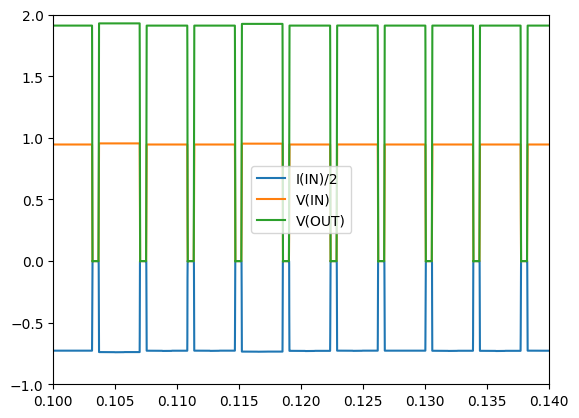

In [104]:
i = 2
I = (analysis[f"XMLP:IN_H{i}"]-analysis[f"XMLP:XACT_H{i}:INN"])/0.001 * 1e5
plt.plot(analysis["time"], -I, label="I(IN)/2")
#plt.plot(analysis["time"], analysis.branches[f"B:XMLP:XACT_H{i}:VCVS"], label="I(OUT)")
#plt.plot(analysis.time, analysis["NUDGED"]/1e7, label="nudged")
plt.plot(analysis["time"], analysis[f"XMLP:IN_H{i}"], label="V(IN)")
plt.plot(analysis["time"], analysis[f"XMLP:OUT_H{i}"]*1.01, label="V(OUT)")
plt.xlim(0.1, 0.14)
plt.ylim(-1,2)
plt.legend()

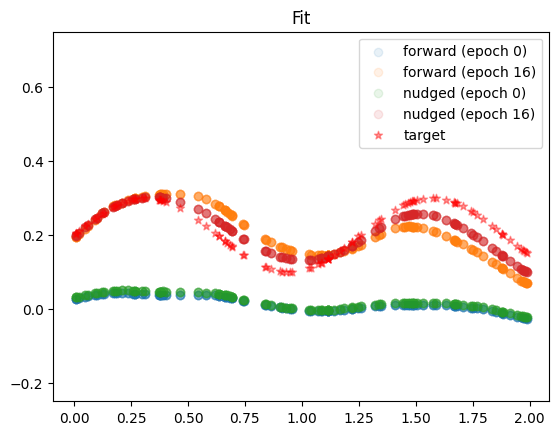

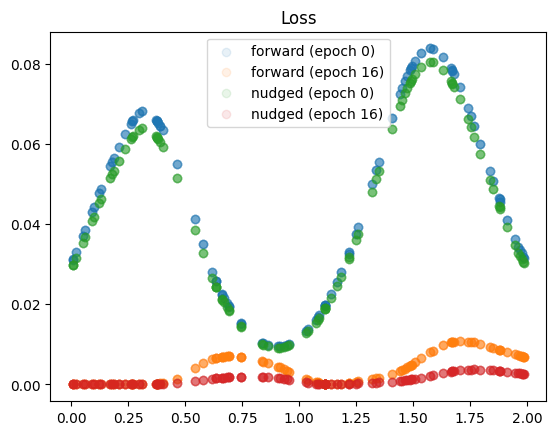

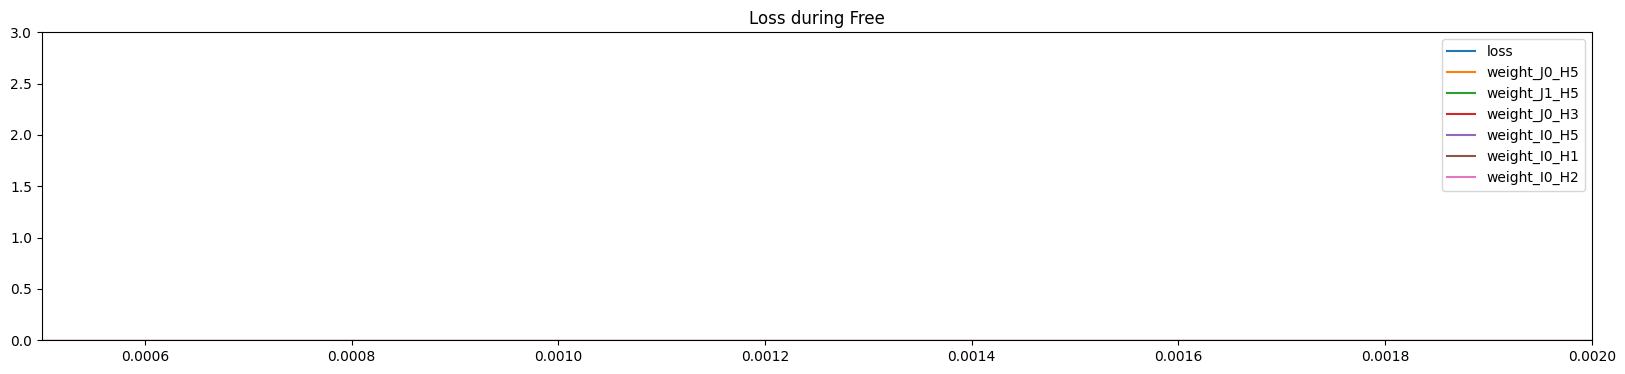

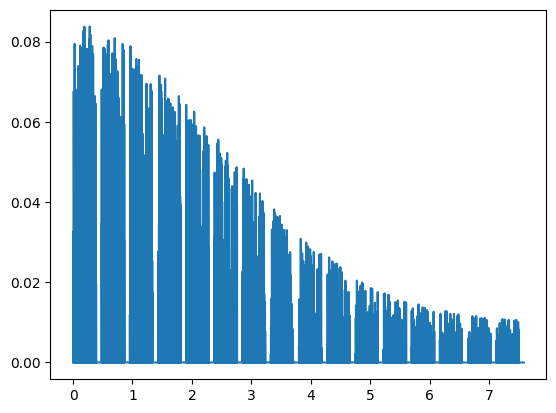

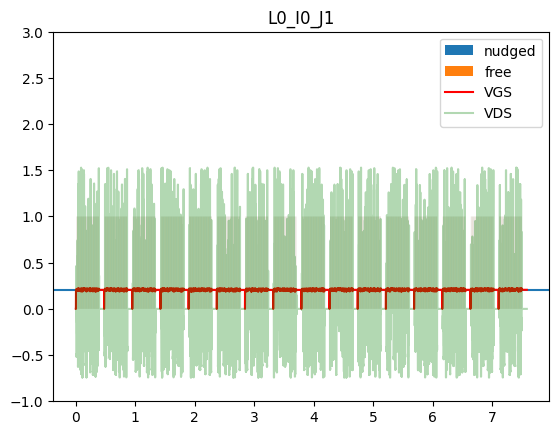

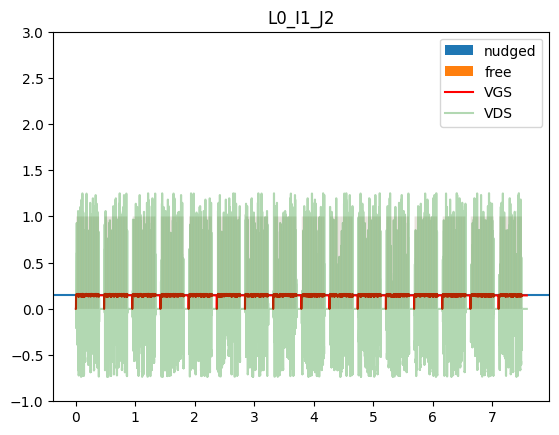

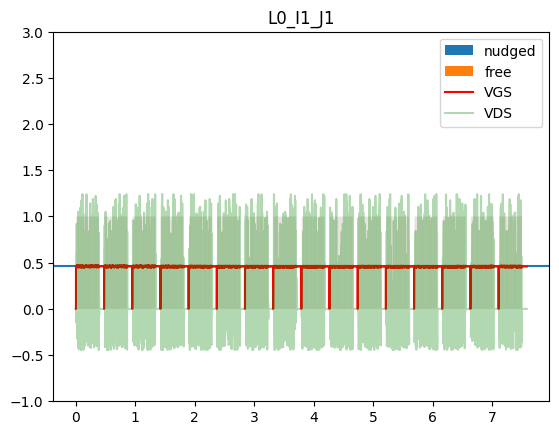

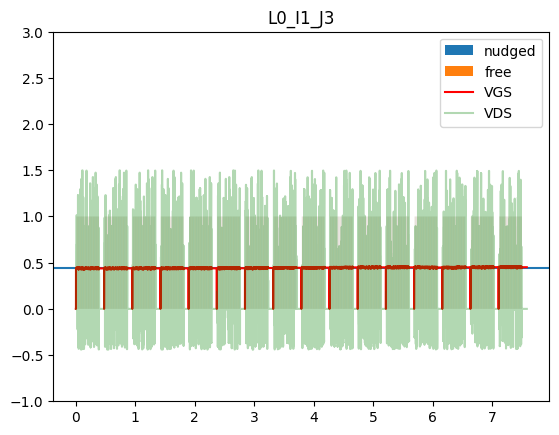

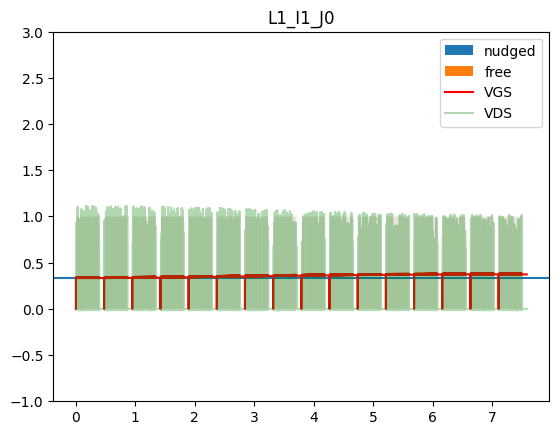

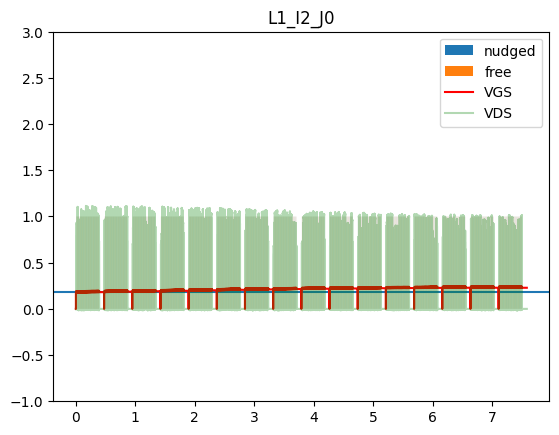

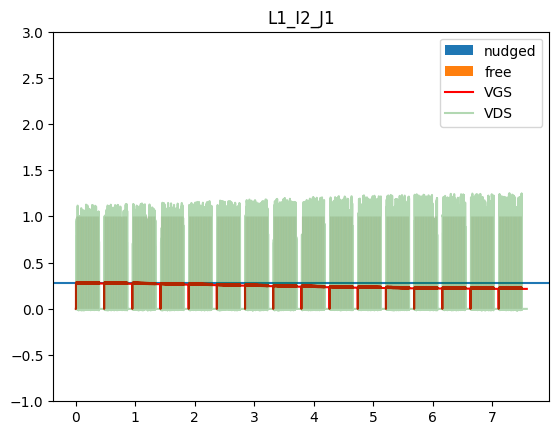

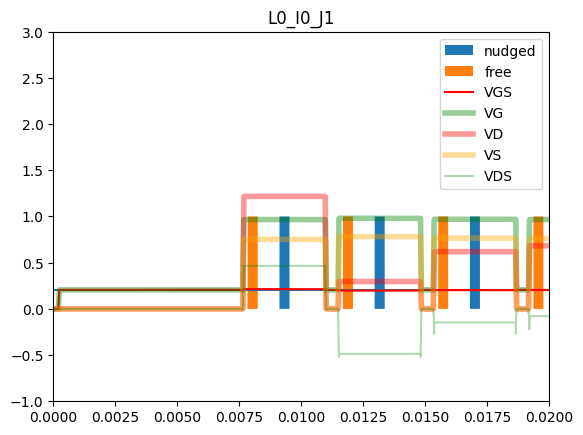

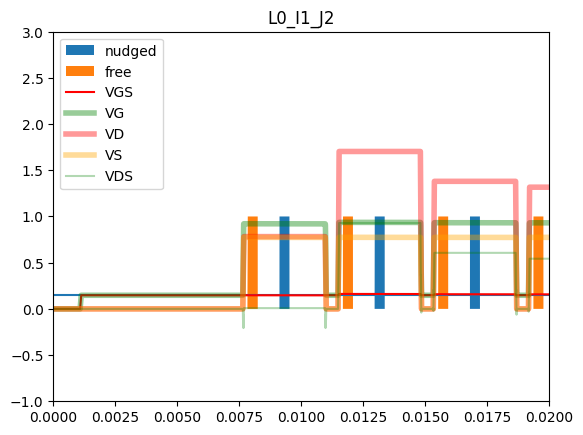

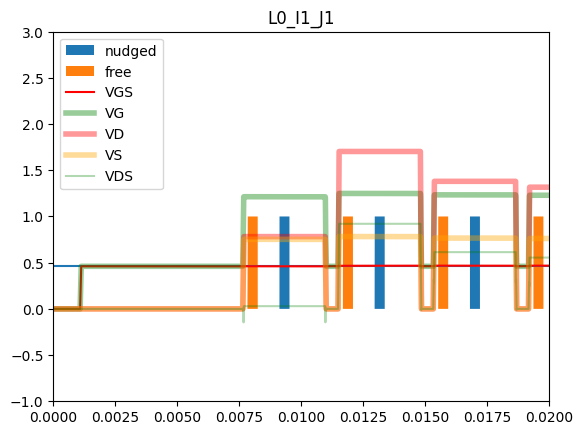

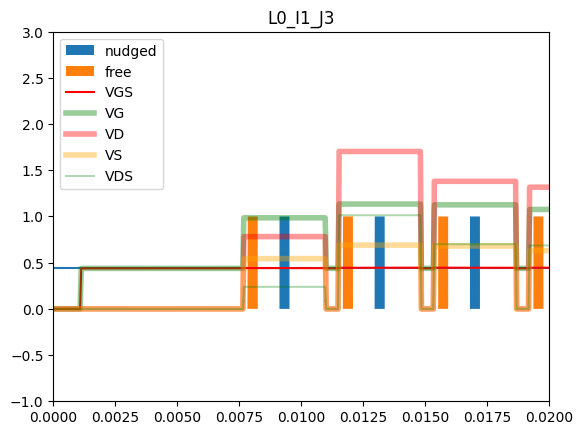

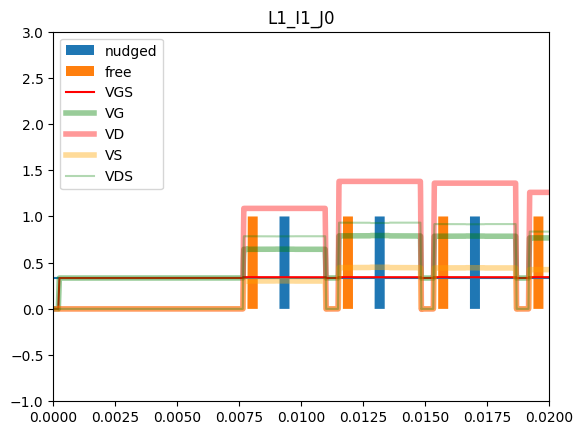

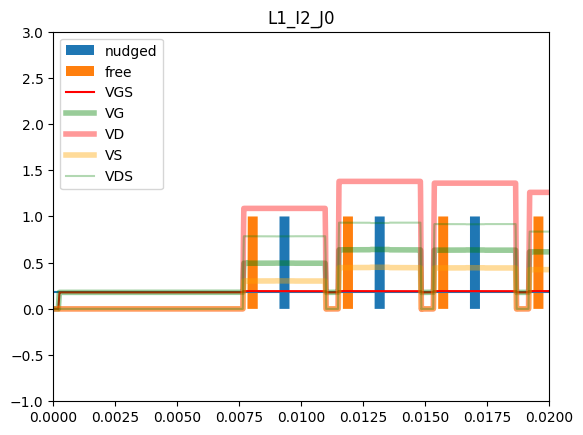

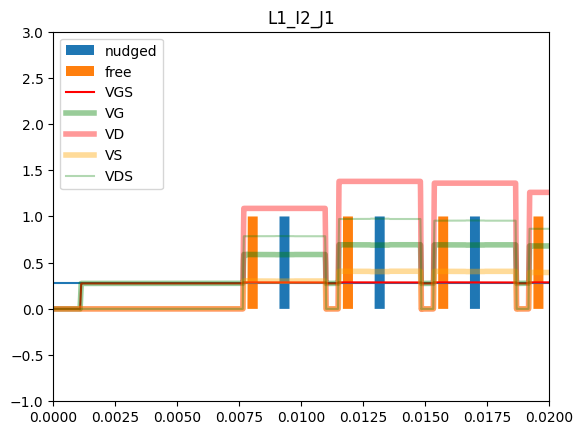

In [112]:
import numpy as np

analysis = dict()
epoch_times = []
for node in analyses[0].nodes:
    analysis[node] = np.array(analyses[0][node])
epoch_times.append(0)
for a in analyses[1:]:
    for node in a.nodes:
        if node == "time":
            epoch_times.append(analysis[node].max().item())
            analysis[node] = np.concatenate([analysis[node], analysis[node].max()+np.array(a[node])])
        else:
            analysis[node] = np.concatenate([analysis[node], np.array(a[node])])
    #if len(epoch_times)>7: break
epoch_times.append(analysis["time"].max().item())

x0 = np.array(analysis["X_0"])
y  = np.array(analysis["XMLP:Y_0"]-analysis["XMLP:Y_1"])
y_free  = np.array(analysis["XMLP:Y_0_FREE"]-analysis["XMLP:Y_1_FREE"])
nudged = np.array(analysis["NUDGED"] )
free = np.array(analysis["FREE"])
loss   = np.array(analysis["XMLP:LOSS"])
time   = np.array(analysis["time"])
during_nudged = np.abs(nudged - nudged.max()) < 1e-2
during_free = np.abs(free-free.max()) < 1e-2
late = time > epoch_times[-2]
early = (time < epoch_times[1])

plt.title("Fit")
for phase, select in [
        (f"forward (epoch 0)", during_free & early),
        (f"forward (epoch {len(epoch_times)-1})", during_free & late),
        (f"nudged (epoch 0)", during_nudged & early),
        (f"nudged (epoch {len(epoch_times)-1})", during_nudged & late), 
    ]:
    plt.scatter(x0[select], y[select], alpha=0.1, label=phase)
    #plt.xlim(0.9,2.2)
plt.scatter(X[:,0], Y[:,0], color="red", alpha=0.4, label="target", marker='*')
    # lr = 2e-5
legend = plt.legend()
plt.ylim(-0.25,0.75)
plt.savefig("fig_sine_11.png")
plt.show()


plt.title("Loss")
for phase, select in [
        ("forward (epoch 0)", during_free & early),
        (f"forward (epoch {len(epoch_times)-1})", during_free & late),
        ("nudged (epoch 0)", during_nudged & early),
        (f"nudged (epoch {len(epoch_times)-1})", during_nudged & late), 
    ]:
    plt.scatter(x0[select], loss[select], alpha=0.1, label=phase)
legend = plt.legend()
plt.savefig("fig_loss_11.png")
plt.show()


select = during_free
plt.figure(figsize=(20,4))
plt.title("Loss during Free")
plt.fill_between(time, y1=0, y2=nudged, alpha=0.1, color="blue")
plt.fill_between(time, y1=0, y2=free, alpha=0.1, color="red")

plt.step(time[select], loss[select]*100, label="loss", where="post")
plot_weights = ["L1_I5_J0", "L1_I5_J1", 
                "L0_I0_J0", "L0_I0_J1", "L0_I0_J2", "L0_I0_J3"]
for (j, h) in [(0, 5), (1, 5), (0, 3)]:
    Vgs = np.array(analysis[f"XMLP:XWEIGHT_J{j}_H{h}:MEM"]) - np.array(analysis[f"XMLP:Y_{j}"])
    plt.step(time[select], Vgs[select], label=f"weight_J{j}_H{h}", where="post")
for (i, h) in [(0, 5), (0, 1), (0, 2)]:
    Vgs = np.array(analysis[f"XMLP:XWEIGHT_I{j}_H{h}:MEM"] - analysis[f"XMLP:IN_H{h}"])
    plt.step(time[select], Vgs[select], label=f"weight_I{j}_H{h}", where="post")

for t in epoch_times: plt.axvline(t, color="pink")


plt.legend()
plt.xlim(0.0005, 0.002)
plt.ylim(0, 3)
plt.savefig("fig_loss_123.png")
plt.show()


plt.plot(time, loss*during_free)
plt.show()
for full_length in [True, False]:
    for l, i, j in [(0,0,1), (0,1,2), (0,1,1),  (0,1,3),  (1,1,0), (1,2,0), (1,2,1)]:
        if l == 1:
            ROUT = np.array(analysis[f"XMLP:Y_{j}"])
            RIN = np.array(analysis[f"XMLP:OUT_H{h}"])
            Vg = np.array(analysis[f"XMLP:XWEIGHT_J{j}_H{i}:MEM"])
            #ref = np.array(analysis[f"XMLP:REF"])
        if l == 0:
            h = j
            ROUT = np.array(analysis[f"XMLP:IN_H{h}"])
            RIN = np.array(analysis[f"X_{i}"])
            Vg = np.array(analysis[f"XMLP:XWEIGHT_I{i}_H{h}:MEM"])
            #ref = np.array(analysis[f"XMLP:IN_H{h}"])
        plt.axhline(initial_weights[l][i,j])
        plt.fill_between(time, y1=0, y2=during_nudged, label="nudged")
        plt.fill_between(time, y1=0, y2=during_free, label="free")
        #plt.plot(ROUT, label="ROUT")
        plt.plot(time, Vg-ROUT, label="VGS", color="red")
        start = epoch_times[0] + epoch_times[0]/2
        if not full_length:
            plt.xlim(start,start+0.02)
            plt.plot(time, Vg, label="VG", color="green", alpha=0.4, linewidth=4)
            plt.plot(time, RIN, label="VD", color="red", alpha=0.4, linewidth=4)
            plt.plot(time, ROUT, label="VS", color="orange", alpha=0.4, linewidth=4)
            #plt.plot(time, ref, label="REF", color="purple", ls='--', linewidth=1)
        plt.plot(time, RIN-ROUT, label="VDS", color="green", alpha=0.3)
        plt.title(f"L{l}_I{i}_J{j}")
        plt.legend()
        plt.ylim(-1, 3)
        plt.show()



In [22]:
mean, meansq, mi, ma = 0, 0, 100, 0
for i in range(dims[0]):
    x = analysis[f"X_{i}"]
    mean  += x.mean()/dims[0]
    meansq += (x**2).mean()/dims[0]
    mi = min(mi, x.min())
    ma = max(ma, x.max())
xstd = (meansq-mean**2)**0.5
xmin = mi
xmax = ma

mean, meansq, mi, ma = 0, 0, 100, 0
for h in range(dims[1]):
    x = analysis[f"XMLP:OUT_H{h}"]
    mean  += x.mean()/dims[1]
    meansq += (x**2).mean()/dims[1]
    mi = min(mi, x.min())
    ma = max(ma, x.max())
hstd = (meansq-mean**2)**0.5
hmin = mi
hmax = ma
([xstd, xmin, xmax], [hstd, hmin, hmax])

ValueError: 

# Full Circuit

In [20]:
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory, DeviceModel
from PySpice.Unit import u_V, u_mV, u_ps, u_ns, u_us, u_ms, u_Ohm, u_kOhm, u_uF, u_uA, u_pF, u_A, u_s
import matplotlib.pyplot as plt
import torch
from torch import nn
import os, warnings, tqdm, logging
import numpy as np

# Synapse: performing a nonlinear analog "multiplication" between weights (MEM) and currents (RIN)
class Synapse(SubCircuitFactory):
    def __init__(self, cap):
        self.NAME = 'synapse'
        self.NODES = ('WWL', 'WBL', 'RIN', 'ROUT')
        super().__init__()
        
        self.S('write_nfet', 'MEM', 'WBL', 'WWL', self.gnd, model='switch')
        #self.M('write_nfet', 'WBL', 'WWL', 'MEM', self.gnd, model='NMOS')
        self.C('cap', 'MEM', 'ROUT', cap, model='capacitor')
        self.M("read_nfet", 'ROUT', 'MEM', 'RIN', 'RIN', model='NMOS')


# Amplifier: a (linear) activation function between layers, amplifying voltages forward and currents backward
class Amplifier(SubCircuitFactory):
    def __init__(self, v_gain, i_gain, shift, saturate=None):
        self.NAME = 'amplifier'
        self.NODES = ('IN', 'OUT')
        super().__init__()
        if (v_gain is not None) and (i_gain is not None):
            self.B('vcvs', 'OUT', self.gnd, voltage_expression=f'{{{shift} + {v_gain} * (V(IN) - {shift})}}')
            self.B('cccs', 'IN', self.gnd, current_expression=f'{{{-i_gain} * I(Bvcvs)}}') #{{{-1/gain} * I(Bvcvs)}}
        else:
            self.R("short", "IN", "OUT", 0) # shorting, should be equivalent to gain=1

# Optimizer: measures Vg during NUDGED phase, clamps it during FREE phase
class Optimizer(SubCircuitFactory):
    def __init__(self, cap, bound_weight_interval=None):
        self.NAME = 'optimizer'
        self.NODES = ['WBL', 'NUDGED', 'FREE']
        super().__init__()                                                                              
        
        self.C("numerics", "WBL", self.gnd, cap/100, model="capacitor")

        self.S('measure', 'WBL', 'IN', 'NUDGED', self.gnd, model='switch')
        self.B('opamp', 'OUT', self.gnd, voltage_expression='{V(IN)}')
        self.S('store', 'OUT', 'STORE', 'NUDGED', self.gnd, model='switch')
        self.C('store', 'STORE', self.gnd, cap, model='capacitor')

        self.S('read', 'STORE', 'IN', 'FREE', self.gnd, model='switch')
        self.S('clamp', 'OUT', 'WBL', 'FREE', self.gnd, model='switch')


class MLP(SubCircuitFactory):
    def __init__(self, dims, weights, biases, X, Y, cols_to_free, beta, v_gain, i_gain, shift, cap=0.05@u_pF,
                 write_start=10@u_ns, write_width=2*50@u_ns, write_pause=2*50@u_ns, write_change=10@u_ns,
                 bitline_offset=20@u_ns, read_width=2*40@u_ns, read_pause=2*70@u_ns, read_change=10@u_ns
        ):
        self.NAME   = 'mlp' 
        self.NODES = ['NUDGED', 'FREE']
        self.NODES += [f'X_{i}' for i in range(dims[0])]
        self.NODES += [f'Y_{j}_{phase}' for j in range(dims[-1]) for phase in ["NUDGED", "FREE"]]
        super().__init__()
        self.model('switch',  'VSWITCH', VON=0.5@u_V, VOFF=0.4@u_V, ROFF=1e11@u_kOhm, RON=0.0001@u_Ohm)
        self.model( # modeled after: https://raw.githubusercontent.com/google/skywater-pdk-libs-sky130_fd_pr/f62031a1be9aefe902d6d54cddd6f59b57627436/cells/nfet_01v8/sky130_fd_pr__nfet_01v8.pm3.spice
            'NMOS', 'NMOS', LEVEL=54, VTO=0.7, L=0.15, W=10, TOX=4.148e-9, XJ=1.5e-7, NDEP=1.7e17,
            NSUB=1.0e20, RSH=0.1, U0=0.030197, VSAT=176320, K1=0.90707349, K2=-0.12949, K3=2.0, DVT0=0.0,
            DVT1=0.53, DVT2=-0.032, ETA0=0.00069413878, NFACTOR=2.015, VOFF=-0.20753, RDSW=65.968, PRWG=0.021507,
            PRWB=0.0, WINT=2.1859e-8, LINT=1.1932e-8, CGSO=2.54e-10, CGDO=2.54e-10, CGBO=1.0e-13, KETA=0.0, A0=1.5,
            AGS=1.25, B0=0.0, B1=0.0, A1=0.0, A2=0.42385546, PCLM=0.14094, PDIBLC1=0.35697215,
            PDIBLC2=0.0084061121, PDIBLCB=-0.10329577, DR0UT=0.50332666, PSCBE1=7.9141988e+8, PSCBE2=1.0e-12,
            PVAG=0.0, DELTA=0.01, ALPHA0=3.0e-8, ALPHA1=0.85, BETA0=13.85
        )
        self.model('diode', 'D')
        self.model('capacitor', 'C')
        self.subcircuit(Synapse(cap=cap))
        self.subcircuit(Amplifier(v_gain, i_gain, shift))
        self.subcircuit(Optimizer(cap=cap))

        weight_set_duration = 0@u_ns
        for l, (d_in, d_out) in enumerate(zip(dims[:-1], dims[1:])):
            # Create Parameter Elements inside Crossbar
            for j in range(d_out):
                for i in range(d_in):
                    self.X(f'weight_L{l}_I{i}_J{j}', 'synapse', f'WWL_L{l}_J{j}', f'WBL_L{l}_I{i}', f'RIN_L{l}_I{i}', f'ROUT_L{l}_J{j}')
                if l<(len(dims)-2):
                    self.X(f'act_L{l}_J{j}', 'amplifier', f'ROUT_L{l}_J{j}', f'RIN_L{l+1}_I{j}') # bidirectional amplifier = linear activation
                #self.R(f'ROUT_L{l}_J{j}', f'ROUT_L{l}_J{j}', self.gnd, 100@u_Ohm) # to debug spikes and improve numerical stability

            if biases is not None:
                for j in range(d_out):
                    self.X(f'bias_L{l}_J{j}', 'synapse', f'WWL_L{l}_J{j}', f'WBL_L{l}_I{d_in}', f'RIN_L{l}_I{d_in}', f'ROUT_L{l}_J{j}')
                    self.R(f'bias_L{l}_J{j}', 'BIAS', f'RIN_L{l}_I{d_in}', 1@u_Ohm)
                weights[l] = torch.cat([weights[l], biases[l][None]], 0)
                d_in += 1

            # Create Control Elements around Crossbar
            for i in range(d_in):
                self.X(f'optim_L{l}_I{i}', 'optimizer',  f'WBL_L{l}_I{i}', 'NUDGED', 'FREE') # stores info for gradient calculation
                self.S(f'set_L{l}_I{i}', f'SET_L{l}_I{i}',  f'WBL_L{l}_I{i}', 'SET', self.gnd, model='switch') # switch connecting SET to WBL (during initial weight setting)
                self.S(f'gndset_L{l}_I{i}', f'RIN_L{l}_I{i}', self.gnd, 'SET', self.gnd, model='switch')
                if l == 0: # X feeds into first layer
                    self.R(f'X_{i}', f'RIN_L0_I{i}', f'X_{i}', 0@u_Ohm)
            
            if l == (len(dims)-2): # Y comes out of last layer
                for j in range(d_out):
                    self.S(f'Y_{j}_NUDGED', f'ROUT_L{l}_J{j}', f'Y_{j}_NUDGED', 'NUDGED', self.gnd, model='switch') # switch triggers storing final layer outputs in NUDGED phase
                    #self.R(f'ROUT_L{l}_J{j}', f'ROUT_L{l}_J{j}', self.gnd, 100@u_Ohm) # to debug spikes and improve numerical stability

            # Set Weights 
            write_period = write_width + write_pause + 2 * write_change
            weight_set_duration = max(write_start + write_period * d_out + write_pause, weight_set_duration)
            for j in range(d_out):
                times = [0@u_ns, write_start+write_period*j, write_start+write_period*j+write_change,
                         write_start+write_period*j+write_change+write_width,
                         write_start+write_period*j+2*write_change+write_width]
                values = [0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V]
                self.PieceWiseLinearVoltageSource(f'WWLset_L{l}_J{j}', f'WWLset_L{l}_J{j}', self.gnd, values=zip(times, values))
                
            for i in range(d_in):
                times  = [0@u_ns]
                values = [0@u_V]
                for j in range(d_out):
                    start = write_start + bitline_offset
                    times += [start+write_period*j,  start+write_period*j+write_change,
                              start+write_period*j + write_change+write_width,
                              start+write_period*j+2*write_change+write_width]
                    values += [0@u_V, weights[l][i, j].item()@u_V, weights[l][i, j].item()@u_V, 0@u_V]
                self.PieceWiseLinearVoltageSource(f'SET_L{l}_I{i}', f'SET_L{l}_I{i}', self.gnd, values=zip(times, values))
        
        times  = [0@u_ns, weight_set_duration, weight_set_duration+write_change]
        values = [1.95@u_V, 1.95@u_V, 0@u_V]
        self.PieceWiseLinearVoltageSource(f'SET', f'SET', self.gnd, values=zip(times, values))
        

        ## Train
        start = weight_set_duration + 2 * write_change + read_pause
        read_period = read_width + read_pause + 2 * read_change
        times = [0@u_ns, start]
        times_outer  = [0@u_ns, start]
        times_inner  = [0@u_ns, start] # pulse slightly shortened by 2*bitline_offset
        times_early  = [0@u_ns, start]
        times_latenudged_earlyfree  = [0@u_ns, start]
        times_outernudged_innerfree = [0@u_ns, start]
        times_late = [0@u_ns, start]
        xvalues = [[0@u_V, 0@u_V,] for i in range(dims[0])]
        yvalues = [[0@u_V, 0@u_V] for i in range(dims[-1])]
        nudged  = [0@u_V, 0@u_V,]
        free    = [0@u_V, 0@u_V,]
        bias    = [0@u_V, 0@u_V]
        n, d_in = X.shape
        for i in range(n):
            for phase in range(2): #'NUDGED', 'FREE'
                times +=       [start+read_period*((i+1)*2+phase), start+read_period*((i+1)*2+phase)+read_change, start+read_period*((i+1)*2+phase)+read_change+read_width, start+read_period*((i+1)*2+phase)+2*read_change+read_width]
                times_outer += [times[-4]-bitline_offset, times[-3]-bitline_offset, times[-2]+bitline_offset, times[-1]+bitline_offset]
                times_inner += [times[-4]+bitline_offset, times[-3]+bitline_offset, times[-2]-bitline_offset, times[-1]-bitline_offset]
                times_early += [times[-4]-bitline_offset, times[-3]-bitline_offset, times[-2]-bitline_offset, times[-1]-bitline_offset]
                times_late  += [times[-4]+bitline_offset, times[-3]+bitline_offset, times[-2]+bitline_offset, times[-1]+bitline_offset]
                times_latenudged_earlyfree  += times_late[-4:]  if phase % 2 == 0 else times_early[-4:]
                times_outernudged_innerfree += times_outer[-4:] if phase % 2 == 0 else times_inner[-4:]
            nudged += [0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V]         # _____|--|________________ NUDGED
            free   += [0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V]         # __________|--|___________ FREE
            bias   += [0@u_V, 1@u_V, 1@u_V, 1@u_V, 1@u_V, 1@u_V, 1@u_V, 0@u_V]               # ___|-----------|_________ BIAS
            for d in range(dims[0]):                                                         # ___|-----------|_________ X
                xvalues[d] += [0@u_V, X[i,d].item()@u_V, X[i,d].item()@u_V, X[i,d].item()@u_V, X[i,d].item()@u_V, X[i,d].item()@u_V, X[i,d].item()@u_V, 0@u_V]
            for d in range(Y.shape[1]):
                yvalues[d] += [0@u_V, Y[i,d].item()@u_V, Y[i,d].item()@u_V, Y[i,d].item()@u_V, Y[i,d].item()@u_V, Y[i,d].item()@u_V, Y[i,d].item()@u_V, 0@u_V]
        
        self.PieceWiseLinearVoltageSource(f'NUDGED', 'NUDGED', '0', values=zip(times, nudged))
        self.PieceWiseLinearVoltageSource(f'FREE', 'FREE', '0', values=zip(times, free))

        self.PieceWiseLinearVoltageSource(f'BIAS', 'BIAS', '0', values=zip(times_outer, bias))
        for d in range(dims[0]):
            self.PieceWiseLinearVoltageSource(f'X_{d}', f'X_{d}', '0', values=zip(times_outer, xvalues[d]))
        for d in range(Y.shape[1]):
            self.PieceWiseLinearVoltageSource(f'target_{d}', f'target_{d}', '0', values=zip(times_outer, yvalues[d]))
        
        self.B("LOSS", "LOSS", self.gnd, voltage_expression=f"{{(V(target_0)-V(ROUT_L{l}_J0)+V(ROUT_L{l}_J1))*(V(target_0)-V(ROUT_L{l}_J0)+V(ROUT_L{l}_J1))}}")
        self.B("NUDGE", "Y_0_NUDGED", "nudge", voltage_expression=f"{{V(target_0)}}")
        self.R("NUDGE", "nudge", "Y_1_NUDGED", 1/beta@u_Ohm)

        for l, d_out in enumerate(dims[1:]):
            for j in range(d_out):
                wwl    = [0@u_V, 0@u_V]
                for i in range(n):
                    if cols_to_free[i, l] == j:
                        wwl += [0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V]
                        #wwl    += [0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V,0@u_V, 0@u_V, 0@u_V]
                    else:
                        wwl    += [0@u_V] * 8
                self.PieceWiseLinearVoltageSource(f'VWWLfree_L{l}_J{j}', f'WWLfree_L{l}_J{j}', '0', values=zip(times_outernudged_innerfree, wwl))
                self.B(f"VWWL_L{l}_J{j}", f"WWL_L{l}_J{j}", self.gnd, voltage_expression=f"{{V(WWLfree_L{l}_J{j})+V(WWLset_L{l}_J{j})}}")
        self.duration = max(times_outer)*1.2

# initialize data
n = 100
X = torch.rand(n, 2)
X[:,1:2] = 1-X[:,0:1]
Y = (X[:,0:1]*10).cos()*0.2 + 0.2
X *= 2
#X += 0.5
# initialize network parameters
dims = [X.shape[1], 16, Y.shape[1]*2] # input, hidden, output (both X and Y are 1d, but computed as difference between two positive outputs)
if dims[1] < 128: print("small d_hidden, don't expect a good fit!")
weights = [torch.rand(d_in, d_out)*2 + 0.5 for l, (d_in, d_out) in enumerate(zip(dims[:-1], dims[1:]))]
biases  = None #[torch.rand(d_out)*0 + 0.8 for d_in, d_out in zip(dims[:-1], dims[1:])]

initial_weights = [_.clone() for _ in weights]
# initialize training hyperparameters
epochs = 3
beta = 0.001
v_gain = 1#5
i_gain = 1
shift = 0
slowdown_factor = 40

# silence xyce warnings
logging.basicConfig(filename='pyspice_warnings.log', level=logging.WARNING, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
pyspice_logger = logging.getLogger('PySpice')
pyspice_logger.setLevel(logging.WARNING)

# simulate
analyses = []
for epoch in (bar := tqdm.tqdm(range(epochs))):
    # sample columns to free at each datapoint
    cols_to_update = torch.stack([torch.arange(d).repeat(n//d+1)[torch.randperm(d*(n//d+1))][:n] for d in dims[1:]]).T

    # shuffle data
    perm = torch.randperm(n)
    X, Y = X[perm], Y[perm]
    
    # run transient simulation of current epoch
    bar.set_description(f"--- preparing epoch {epoch}")
    circuit = Circuit('Crossbar Circuit')
    circuit.subcircuit(mlp := MLP(
        dims, weights, biases, X, Y, cols_to_update, beta, v_gain, i_gain, shift, 
        write_start=slowdown_factor*10@u_ns, write_width=slowdown_factor*100@u_ns, write_pause=slowdown_factor*100@u_ns, write_change=slowdown_factor*10@u_ns,
        bitline_offset=slowdown_factor*40@u_ns, read_width=slowdown_factor*100@u_ns, read_pause=slowdown_factor*140@u_ns, read_change=slowdown_factor*10@u_ns
    ))
    circuit.X('mlp', 'mlp', *mlp.NODES)
    simulator = circuit.simulator(simulator="xyce-parallel")
    bar.set_description(f"----- running epoch {epoch}")
    analysis = simulator.transient(step_time=slowdown_factor*5@u_ns, end_time=mlp.duration * 1.01)
    bar.set_description(f"----- saving epoch {epoch}")
    analyses.append(analysis)

    # set parameter variables to the most recent values
    nudged = np.array(analysis["NUDGED"])
    during_nudged = np.abs(nudged - nudged.max()) < 1e-2
    time = np.array(analysis.time)
    for l, (d_in, d_out) in enumerate(zip(dims[:-1], dims[1:])):
        for j in range(d_out):
            for i in range(d_in):
                weights[l][i, j] = (analysis[f"XMLP:XWEIGHT_L{l}_I{i}_J{j}:MEM"] - analysis[f"XMLP:RIN_L{l}_I{i}"])[-10:].mean().item()
            if biases is not None:
                biases[l][j] = (analysis[f"XMLP:XBIAS_L{l}_J{j}:MEM"] - analysis[f"XMLP:RIN_L{l}_I{d_in}"])[-10:].mean().item()

print('done')
# idea: maximize backprop strengh by preventing sideways flows somehow (negative Vds), e.g. via diodes

small d_hidden, don't expect a good fit!


----- running epoch 0:   0%|          | 0/3 [00:46<?, ?it/s]


KeyboardInterrupt: 

In [49]:
import numpy as np

analysis = dict()
epoch_times = []
for node in analyses[0].nodes:
    analysis[node] = np.array(analyses[0][node])
epoch_times.append(0)
for a in analyses[1:]:
    for node in a.nodes:
        if node == "time":
            epoch_times.append(analysis[node].max().item())
            analysis[node] = np.concatenate([analysis[node], analysis[node].max()+np.array(a[node])])
        else:
            analysis[node] = np.concatenate([analysis[node], np.array(a[node])])

x0 = np.array(analysis["X_0"])
y  = np.array(analysis["XMLP:ROUT_L1_J0"]-analysis["XMLP:ROUT_L1_J1"])
nudged = np.array(analysis["NUDGED"] )
free = np.array(analysis["FREE"])
loss   = np.array(analysis["XMLP:LOSS"])
time   = np.array(analysis["time"])
during_nudged = np.abs(nudged - nudged.max()) < 1e-2
during_free = np.abs(free-free.max()) < 1e-2
during_forward = during_nudged | during_free
late = time > time[during_nudged].max() * 0.9
early = (time < time[during_nudged].max() * 0.2) & (time > time[during_nudged].max() * 0)

plt.title("Fit")
for phase, select in [
        #("nudged (early)", during_nudged & early),
        ("forward (initially)", during_free & early),
        #("nudged (late)", during_nudged & late), 
        ("forward (end of training)", during_free & late),
    ]:
    plt.scatter(x0[select], y[select], alpha=0.1, label=phase)
    #plt.xlim(0.9,2.2)
plt.scatter(X[:,0], Y[:,0], color="red", alpha=0.4, label="target", marker='*')
    # lr = 2e-5
legend = plt.legend()
plt.ylim(-0.25,0.75)
plt.savefig("fig_sine_11.png")
plt.show()


plt.title("Loss")
for phase, select in [
        ("nudged (initially)", during_nudged & early),
        ("forward (initially)", during_free & early),
        ("nudged (end of training)", during_nudged & late), 
        ("forward (end of training)", during_free & late),
    ]:
    plt.scatter(x0[select], loss[select], alpha=0.1, label=phase)
legend = plt.legend()
plt.savefig("fig_loss_11.png")
plt.show()


select = during_forward
plt.figure(figsize=(20,4))
plt.title("Loss during Free")
plt.fill_between(time[select], y1=0, y2=nudged[select], alpha=0.1, color="blue")
plt.fill_between(time[select], y1=0, y2=free[select], alpha=0.1, color="red")

plt.step(time[select], loss[select]*100, label="loss", where="post")
plot_weights = ["L1_I5_J0", "L1_I5_J1", 
                "L0_I0_J0", "L0_I0_J1", "L0_I0_J2", "L0_I0_J3"]
for w in plot_weights:
    l, i, j = (_[1:] for _ in w.split("_"))
    Vgs = np.array(analysis[f"XMLP:XWEIGHT_{w}:MEM"]) - np.array(analysis[f"XMLP:ROUT_L{l}_J{j}"])
    plt.step(time[select], Vgs[select], label="weight_"+w, where="post")
w = plot_weights[0]
for t in epoch_times: plt.axvline(t, color="pink")


plt.legend()
plt.xlim(0.0005, 0.002)
plt.ylim(0, 3)
plt.savefig("fig_loss_123.png")
plt.show()



plt.figure(figsize=(20,4))

plt.plot(time, nudged/2, label="nudged/2")
plt.plot(time, free/2, label="free/2")
l = 0
plt.plot(time, analysis[f"XMLP:XOPTIM_L{l}_I_:STORE"], label="STORE_I0", linewidth=5, alpha=0.3)
plt.plot(time, analysis[f"XMLP:WBL_L{l}_I0"], label="WBL_I0", linewidth=3, alpha=0.3)
plt.plot(time, analysis[f"XMLP:RIN_L{l}_I0"], label="RIN_I0", linewidth=5, alpha=0.3)
plt.plot(time, y, label="Y")
plt.xlim(0.0005, 0.001)
plt.legend()

KeyError: 'XMLP:ROUT_L1_J0'

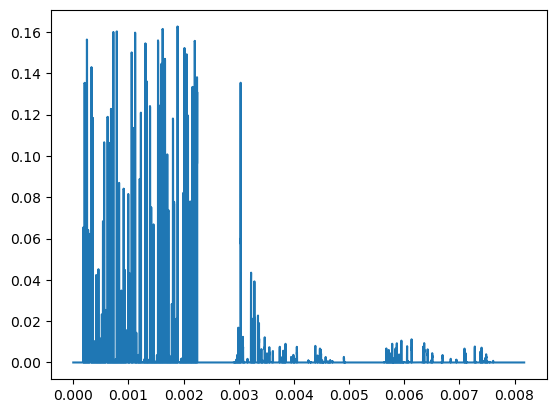

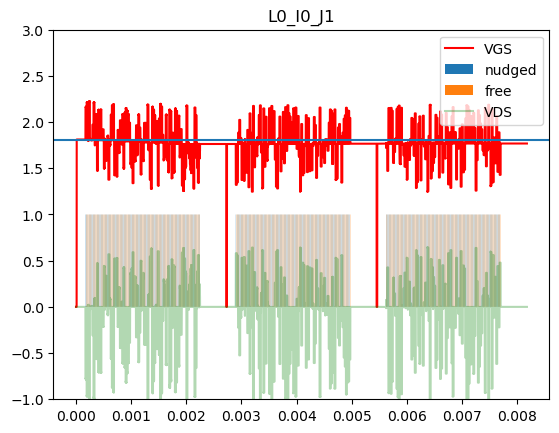

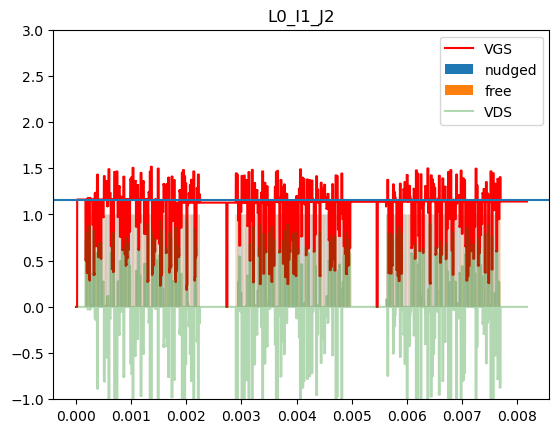

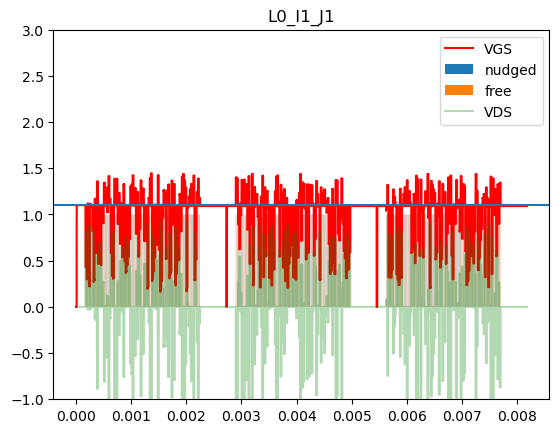

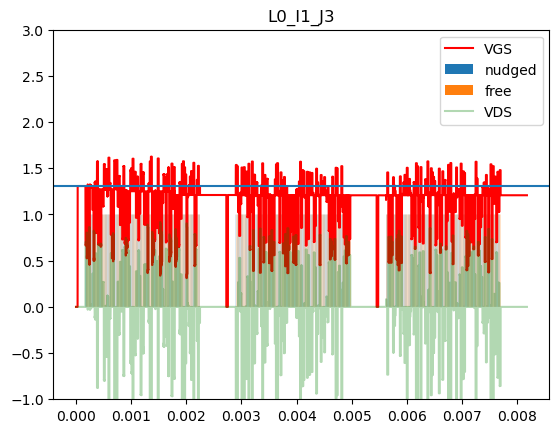

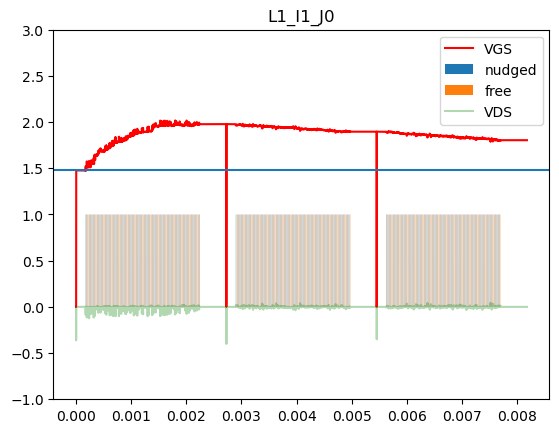

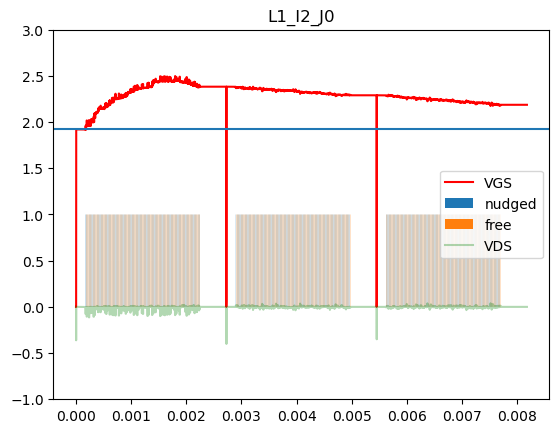

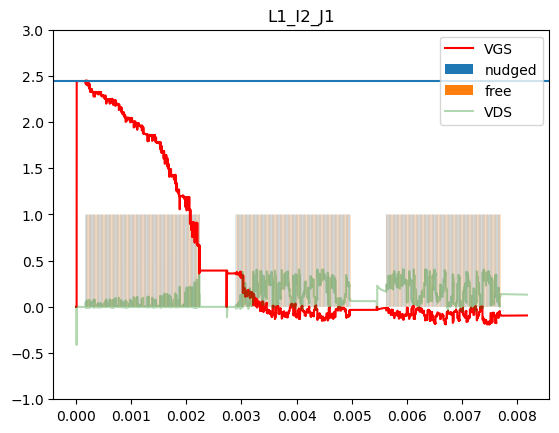

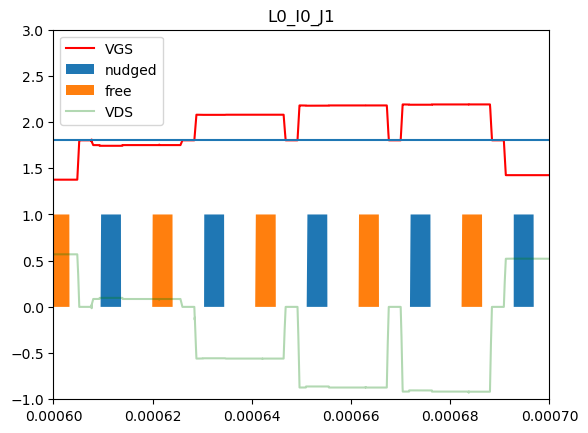

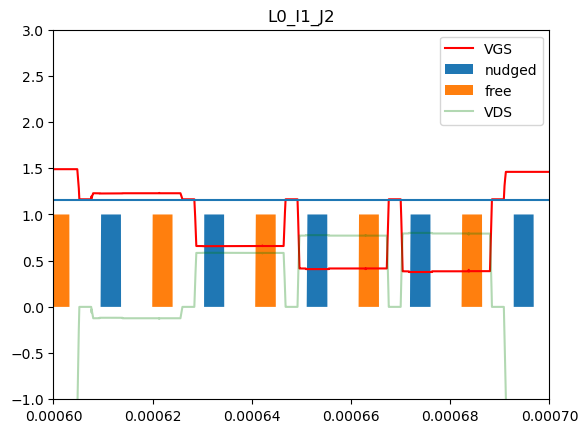

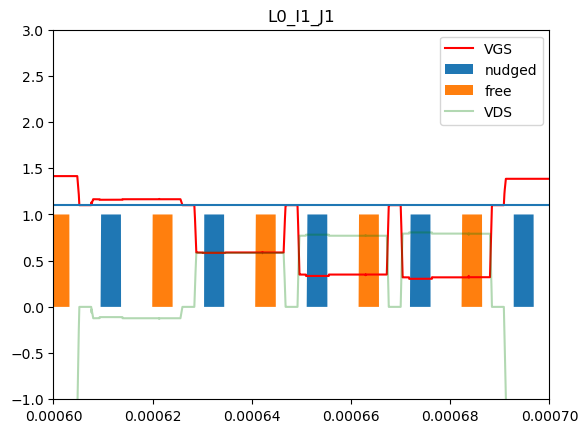

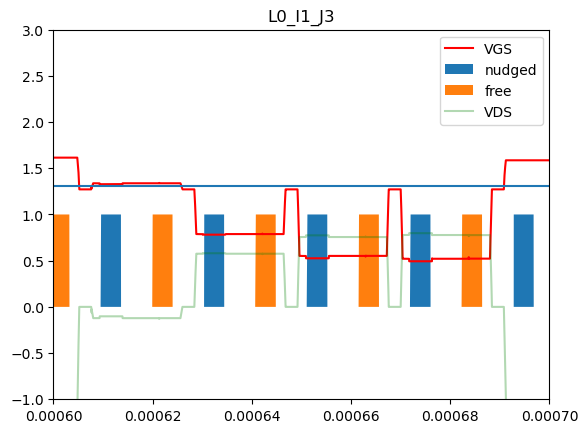

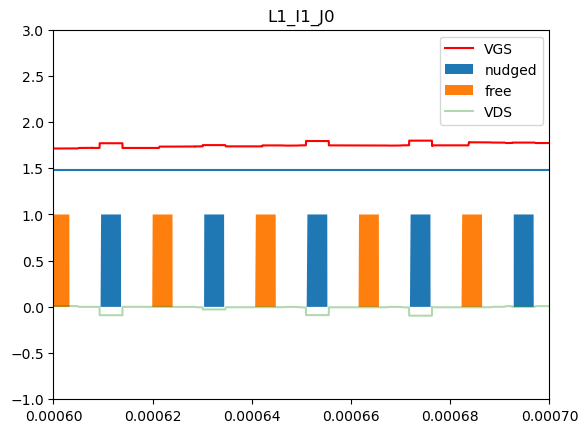

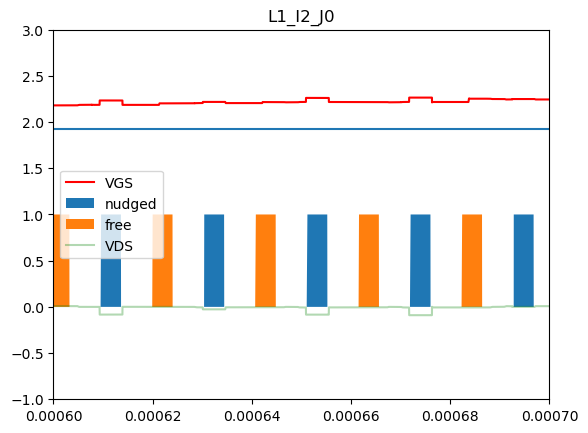

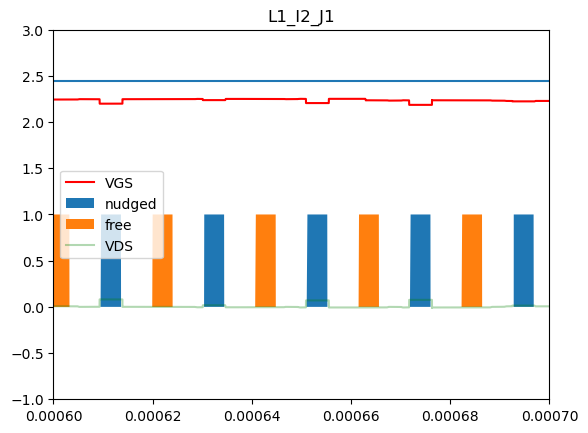

(0.0, 3e-05)

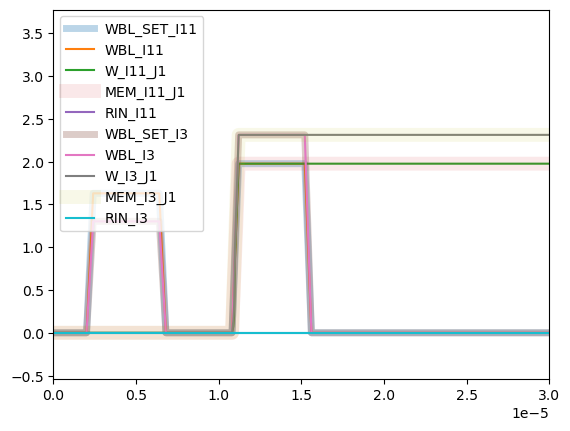

In [45]:
plt.plot(time, loss*during_free)
plt.show()
for full_length in [True, False]:
    for l, i, j in [(0,0,1), (0,1,2), (0,1,1),  (0,1,3),  (1,1,0), (1,2,0), (1,2,1)]:
        Vgs = np.array(analysis[f"XMLP:XWEIGHT_L{l}_I{i}_J{j}:MEM"]) - np.array(analysis[f"XMLP:RIN_L{l}_I{i}"])

        plt.plot(time, Vgs, label="VGS", color="red")
        plt.axhline(initial_weights[l][i,j])
        plt.fill_between(time,y1=0, y2=during_nudged, label="nudged")
        plt.fill_between(time,y1=0, y2=during_free, label="free")
        RIN =  np.array(analysis[f"XMLP:RIN_L{l}_I{i}"])
        ROUT =  np.array(analysis[f"XMLP:ROUT_L{l}_J{j}"])
        plt.plot(time, RIN-ROUT, label="VDS", color="green", alpha=0.3)
        #plt.plot(ROUT, label="ROUT")
        if not full_length: plt.xlim(0.0006,0.0007)
        plt.title(f"L{l}_I{i}_J{j}")
        plt.legend()
        plt.ylim(-1, 3)
        plt.show()

time = analysis["time"]
for l, i, j in [(1, 11, 1), (1, 3, 1)]:
    plt.plot(time, np.array(analysis[f"XMLP:SET_L{l}_I{i}"]), label=f"WBL_SET_I{i}", linewidth=5, alpha=0.3)
    plt.plot(time, np.array(analysis[f"XMLP:WBL_L{l}_I{i}"]), label=f"WBL_I{i}")
    Vgs = np.array(analysis[f"XMLP:XWEIGHT_L{l}_I{i}_J{j}:MEM"]) - np.array(analysis[f"XMLP:ROUT_L{l}_J{j}"])
    plt.plot(time, Vgs, label=f"W_I{i}_J{j}")
    plt.plot(time, np.array(analysis[f"XMLP:XWEIGHT_L{l}_I{i}_J{j}:MEM"]), label=f"MEM_I{i}_J{j}", linewidth=10, alpha=0.1)
    plt.plot(time, np.array(analysis[f"XMLP:RIN_L{l}_I{i}"]), label=f"RIN_I{i}")
    #plt.plot(time, np.array(analysis[f"XMLP:WWL_L{l}_J{j}"]), label="WWL")
#plt.plot(time, np.array(analysis[f"XMLP:SET"]), label="SET")
plt.legend()
plt.xlim(0,0.00003)
#plt.ylim(0.7, 1.7)


Netlist warning: No print specified

Netlist warning in file /tmp/tmpp4yoniyt/input.cir at or near line 6

Netlist warning in file /tmp/tmpp4yoniyt/input.cir at or near line 6

Netlist warning in file /tmp/tmpp4yoniyt/input.cir at or near line 6

Netlist warning in file /tmp/tmpp4yoniyt/input.cir at or near line 6

Netlist warning in file /tmp/tmpp4yoniyt/input.cir at or near line 6

Netlist warning in file /tmp/tmpp4yoniyt/input.cir at or near line 6

Netlist warning in file /tmp/tmpp4yoniyt/input.cir at or near line 6

Netlist warning in file /tmp/tmpp4yoniyt/input.cir at or near line 2

Netlist warning: No print specified

Netlist warning in file /tmp/tmp5r4pqll1/input.cir at or near line 6

Netlist warning in file /tmp/tmp5r4pqll1/input.cir at or near line 6

Netlist warning in file /tmp/tmp5r4pqll1/input.cir at or near line 6

Netlist warning in file /tmp/tmp5r4pqll1/input.cir at or near line 6

Netlist warning in file /tmp/tmp5r4pqll1/input.cir at or near line 6

Netlist warning

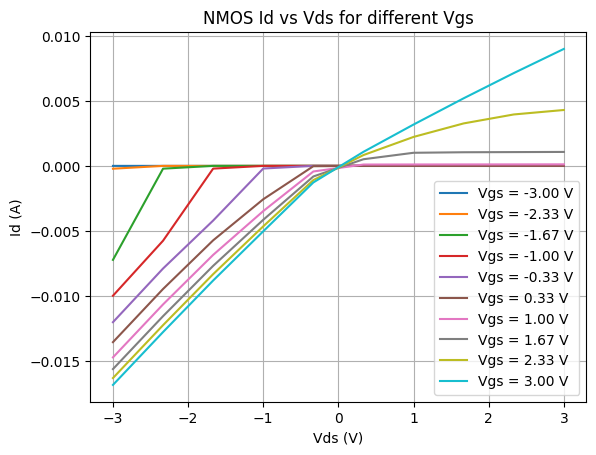

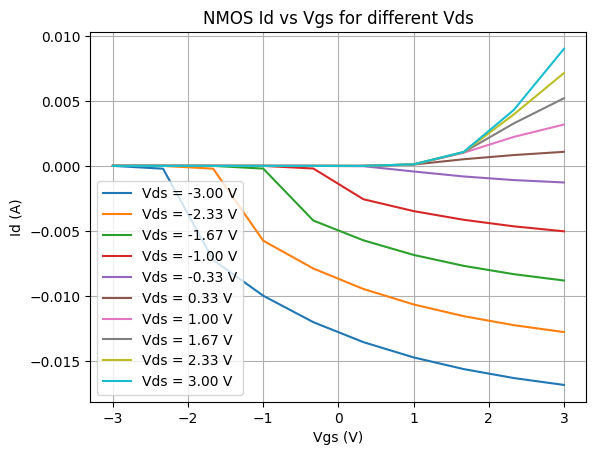

In [18]:
import matplotlib.pyplot as plt
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import numpy as np
# Create a minimal circuit simulation of the NMOS model
circuit = Circuit('NMOS Characteristic Curves')
circuit.model(
            'NMOS', 'NMOS', LEVEL=54, VTO=0.7, L=0.15, W=10, TOX=4.148e-9, XJ=1.5e-7, NDEP=1.7e17,
            NSUB=1.0e20, RSH=0.1, U0=0.030197, VSAT=176320, K1=0.90707349, K2=-0.12949, K3=2.0, DVT0=0.0,
            DVT1=0.53, DVT2=-0.032, ETA0=0.00069413878, NFACTOR=2.015, VOFF=-0.20753, RDSW=65.968, PRWG=0.021507,
            PRWB=0.0, WINT=2.1859e-8, LINT=1.1932e-8, CGSO=2.54e-10, CGDO=2.54e-10, CGBO=1.0e-13, KETA=0.0, A0=1.5,
            AGS=1.25, B0=0.0, B1=0.0, A1=0.0, A2=0.42385546, PCLM=0.14094, PDIBLC1=0.35697215,
            PDIBLC2=0.0084061121, PDIBLCB=-0.10329577, DR0UT=0.50332666, PSCBE1=7.9141988e+8, PSCBE2=1.0e-12,
            PVAG=0.0, DELTA=0.01, ALPHA0=3.0e-8, ALPHA1=0.85, BETA0=13.85
        )

# Define the NMOS transistor
circuit.M(1, 'drain', 'gate', circuit.gnd, circuit.gnd, model='NMOS',)

# Define the voltage sources
circuit.V(1, 'gate', circuit.gnd, 0@u_V)
circuit.V(2, 'drain', 'rgnd', 0@u_V)
circuit.R('rgnd', 'rgnd', circuit.gnd, 10@u_Ohm)

# Sweep Vgs and Vds
vgs_values = np.linspace(-3, 3, 10)  # Gate-Source voltage values
vds_values = np.linspace(-3, 3, 10)  # Drain-Source voltage values

# Store the results
results = {}

for vgs in vgs_values:
    circuit['V1'].dc_value = vgs@u_V
    id_values = {}
    for vds in vds_values:
        circuit['V2'].dc_value = vds@u_V
        simulator = circuit.simulator(temperature=25, nominal_temperature=25, simulator="xyce-serial")
        analysis = simulator.operating_point()
        id_values[vds] = float(-analysis["rgnd"])
    results[vgs] = id_values

# Plot the results
for vgs in vgs_values:
    id_values = [results[vgs][vds] for vds in vds_values]
    plt.plot(vds_values, id_values, label=f'Vgs = {vgs:.2f} V')

plt.xlabel('Vds (V)')
plt.ylabel('Id (A)')
plt.title('NMOS Id vs Vds for different Vgs')
plt.legend()
plt.grid()
plt.show()


for vds in vds_values:
    id_values = [results[vgs][vds] for vgs in vgs_values]
    plt.plot(vgs_values, id_values, label=f'Vds = {vds:.2f} V')

plt.xlabel('Vgs (V)')
plt.ylabel('Id (A)')
plt.title('NMOS Id vs Vgs for different Vds')
plt.legend()
plt.grid()
plt.show()


In [17]:
analysis._simulation